## **InceptionResNetV2 CNN Model K-fold**

### **1. Import the necessary libraries**


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [2]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Building InceptionResNetV2 Model**


In [3]:
def create_inceptionResNetV2_model(
    learning_rate=0.001, dropout_rate=0.0, dense_units=128
):
    # Load pre-trained ResNet101 model without top layers
    base_model = InceptionResNetV2(
        weights="imagenet", include_top=False, input_shape=(256, 256, 3)
    )

    # Freeze initial layers to keep pre-trained weights unchanged
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for MRI classification task
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **4. Train the Model**


In [4]:
# Define best parameters Best Parameters: {'dense_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}
learning_rate = 0.001
dropout_rate = 0.2
dense_units = 128
img_size = 256
batch_size = 12

# Store all models and histories
models = {}

# Define the paths
data_dir = f"../DATASETS/kfold_dataset_{img_size}"  # Directory containing train, val, and test directories

# Iterate over the splits
for i in range(5):
    print(f"Fold {i + 1}")
    train_dir = data_dir + f"/train_fold_{i}"
    val_dir = data_dir + f"/val_fold_{i}"

    # ImageDataGenerator for data augmentation and normalization
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
    )

    # Create model with current parameters
    model = create_inceptionResNetV2_model(
        learning_rate=learning_rate, dropout_rate=dropout_rate, dense_units=dense_units
    )

    # # Define callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=val_generator.samples // val_generator.batch_size,
        # callbacks=[early_stopping],
    )

    # Retrieve validation accuracy from history
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    models[i] = {
        "model": model,
        "history": history.history,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
    }

# Save the best model
highest_accuracy = 0
best_model = None
for key, value in models.items():
    if value["val_accuracy"] >= highest_accuracy:
        if value["val_accuracy"] == highest_accuracy:
            if value["val_loss"] < val_loss:
                highest_accuracy = value["val_accuracy"]
                best_model = value["model"]
        else:
            highest_accuracy = value["val_accuracy"]
            best_model = value["model"]

# Save the best model
print(f"Highest Accuracy: {highest_accuracy}")
best_model.save("InceptionResNetV2_model_kfold.h5")

Fold 1
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/25
32/32 [==============================] - 17s 219ms/step - loss: 1.2475 - accuracy: 0.5052 - val_loss: 1.0029 - val_accuracy: 0.6354
Epoch 2/25
32/32 [==============================] - 5s 147ms/step - loss: 0.7763 - accuracy: 0.7109 - val_loss: 0.8466 - val_accuracy: 0.6562
Epoch 3/25
32/32 [==============================] - 5s 149ms/step - loss: 0.6497 - accuracy: 0.7708 - val_loss: 0.8258 - val_accuracy: 0.6667
Epoch 4/25
32/32 [==============================] - 4s 135ms/step - loss: 0.6069 - accuracy: 0.7682 - val_loss: 0.7685 - val_accuracy: 0.6979
Epoch 5/25
32/32 [==============================] - 4s 134ms/step - loss: 0.5500 - accuracy: 0.7891 - val_loss: 0.6967 - val_accuracy: 0.7500
Epoch 6/25
32/32 [==============================] - 4s 132ms/step - loss: 0.5994 - accuracy: 0.7917 - val_loss: 0.7205 - val_accuracy: 0.7396
Epoch 7/25
32/32 [==============================] - 4s 128m

### **5. Evaluate and Visualize Results**


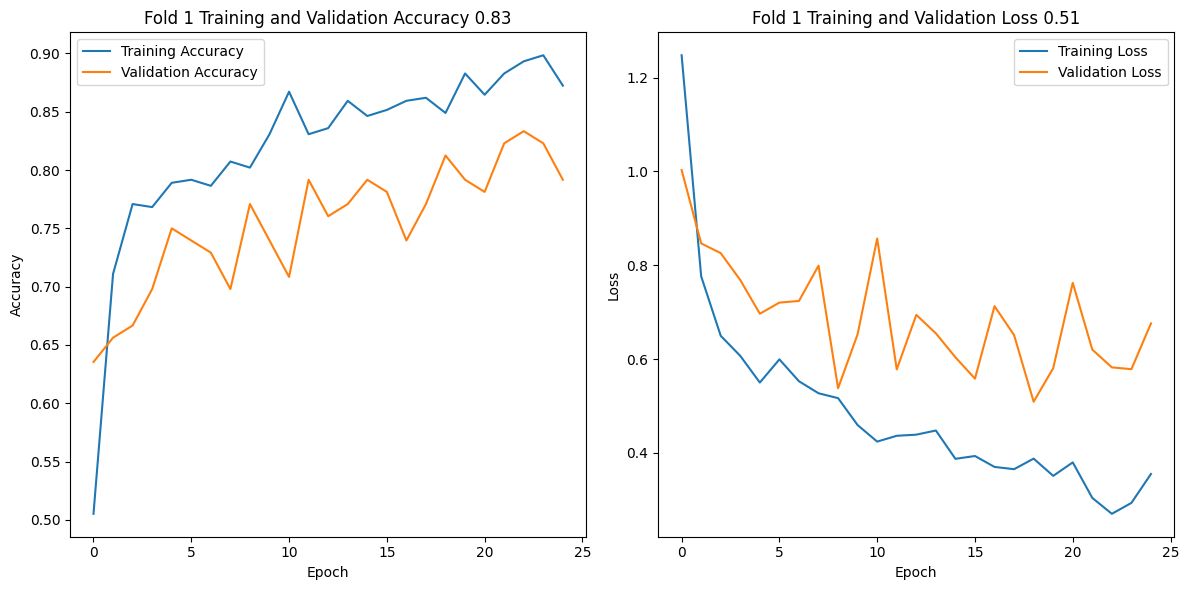

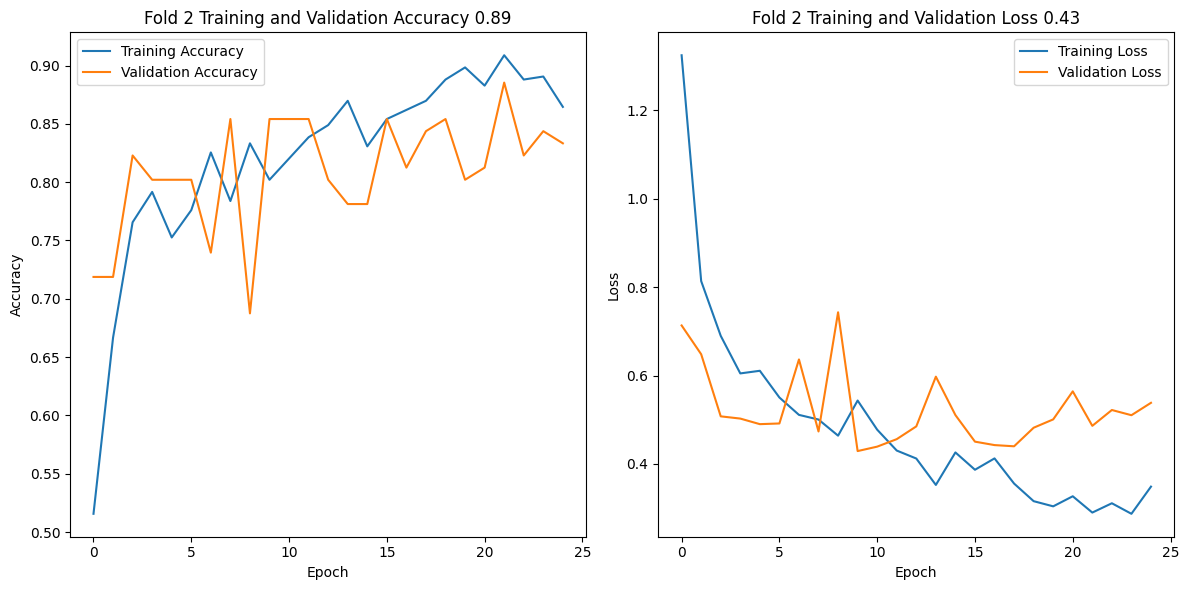

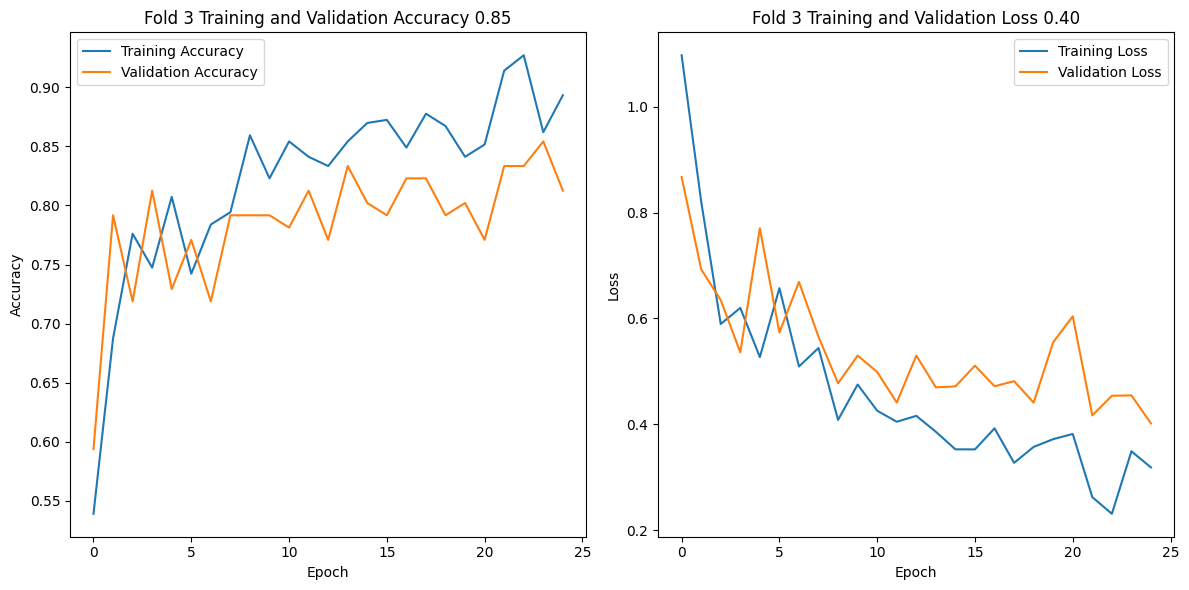

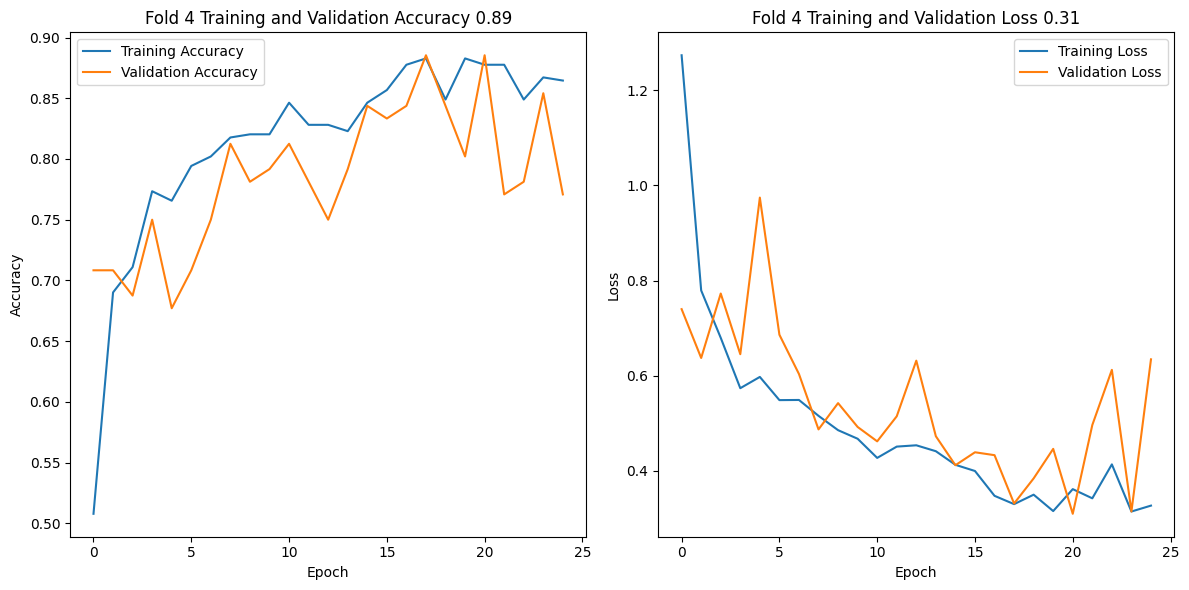

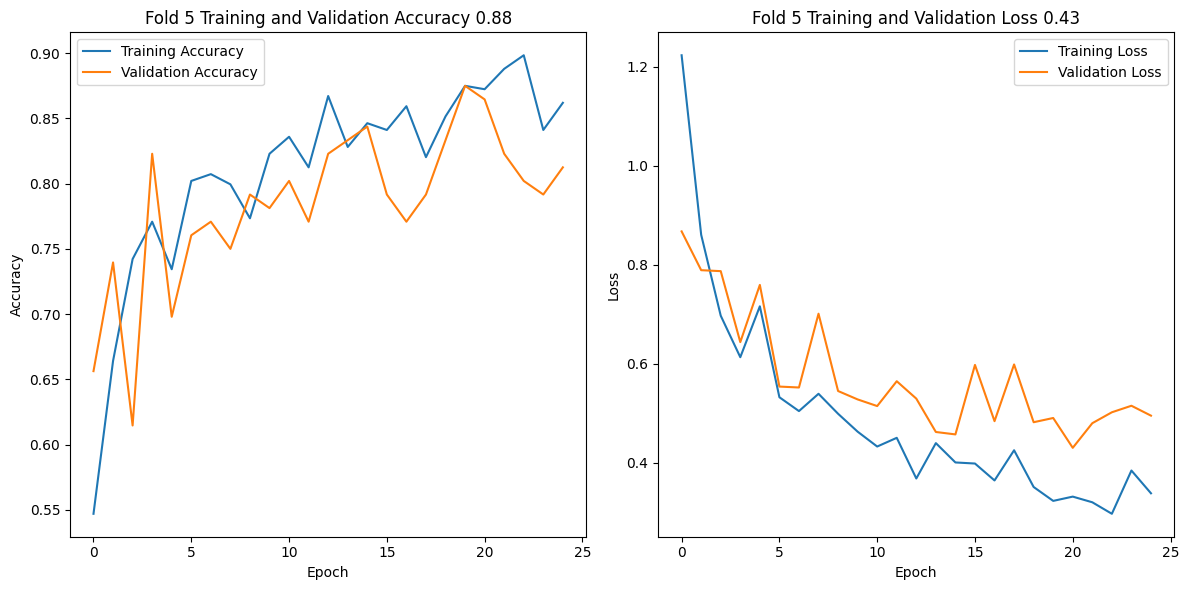

In [5]:
# Plot all training history
for key, value in models.items():
    accuracy = value['val_accuracy']
    loss = value['val_loss']
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(value["history"]["accuracy"], label="Training Accuracy")
    plt.plot(value["history"]["val_accuracy"], label="Validation Accuracy")
    plt.title(f'Fold { key + 1 } Training and Validation Accuracy {accuracy:.2f}')
    plt.xlabel("Epoch")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(value["history"]["loss"], label="Training Loss")
    plt.plot(value["history"]["val_loss"], label="Validation Loss")
    plt.title(f"Fold {key + 1} Training and Validation Loss {loss:.2f}")
    plt.xlabel("Epoch")
    plt.xticks([0, 5, 10, 15, 20, 25])
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()